In [84]:
# установка лемматизатора pymorphy2
!pip install pymorphy2

In [85]:
import numpy as np # Библиотека для работы с массивами данных
from tensorflow.keras.models import Model, load_model # Импортируем модель, метод загрузки предобученной сети 
import re # Импортируем для работы со строками
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
# Импортируем слои для сеток
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D 
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2DTranspose, Lambda, LSTM, Flatten, GlobalAveragePooling1D
from tensorflow.keras import backend as K # Импортируем для подсчета dice_coef
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы 
from tensorflow.keras import utils # Импортируем для работы с категориальными данными 
from google.colab import files # Импортируем для работы с файлами
import matplotlib.pyplot as plt # Импортируем для отрисовки графиков
from gensim.models import word2vec # Импортируем gensim 
import os # Импортируем для работы с файловой системой
import pandas as pd # И мпортируем для работы с DataFrame
import pymorphy2 # Импортируем для работы с леммами
import time # Импортируем для подсчета времени 
import random
import seaborn as sns
sns.set()
import codecs

In [86]:
# Подключаем диск
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# Чтение файла текста из файла, очитска от знаков препинания
def readText(fileName):
  f = codecs.open(fileName, 'r', encoding='utf-8', errors='ignore') #Открываем наш файл для чтения и считываем из него данные 
  text = f.read() #Записываем прочитанный текст в переменную 
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";"]

  for dS in delSymbols: # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ") # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  text = re.sub("[.]", " ", text) 
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (а их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split()) 

  text = text.lower() # Переводим текст в нижний регистр
  return text # Возвращаем тексты

  # Преобразование исходного текста в список из слов в нормальной форме 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ') # Разделяем текст на пробелы
  words = [morph.parse(word)[0].normal_form for word in words] #Переводим каждое слово в нормалную форму  
  return words # Возвращаем слова

# Собираем список индексов и dummy encoded вектора
def get01XSamples(tok_agreem, tags_index):
  tags01 = [] # Список для тегов
  indexes = [] # Здесь будут лежать индексы
 
  for agreement in tok_agreem: # Проходимся по каждому договору-списку
    tag_place = [0, 0, 0, 0, 0, 0] # Создаем вектор [0,0,0,0,0,0]
    for ex in agreement: # Проходимся по каждому слову договора
        if ex in tags_index: # Смотрим, если индекс оказался нашим тегом
          place = np.argwhere(tags_index==ex) # Записываем под каким местом лежит этот тег в своем списке
          if len(place)!=0: # Проверяем, чтобы тег действительно был
            if place[0][0]<6: # Первые шесть тегов в списке - открывающие
              tag_place[place[0][0]] = 1    # Поэтому ставим 1
            else: 
              tag_place[place[0][0] - 6] = 0  # Остальные теги закрывающие, так что меняем на ноль
        else:          
          tags01.append(tag_place.copy()) # Расширяем наш список с каждой итерацией. Получаем в конце длинный список из всех тегов в одном 
          indexes.append(ex) # Докидываем индекс слова в список индексов

  return indexes, tags01

# Получение списка слов из индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) # Берем пары значений всего словаря и размечаем наоборот, т.е. value:key
  words = [reverse_word_map.get(letter) for letter in x] # Вытаскиваем по каждому ключу в список
  return words # Возвращаем полученный текст

# Формируем выборку из индексов
def getSetFromIndexes(wordIndexes, xLen, step): 
  xBatch = [] # Лист для фрагментов текста
  wordsLen = len(wordIndexes) # Определяем длину текста
  index = 0 # Задаем стартовый индекс
  
  while (index + xLen <= wordsLen): # Пока сумма индекса с длинной фрагмента меньше или равна числу слов в выборке
    xBatch.append(wordIndexes[index:index+xLen]) # Добавляем X в лист фразментов текста
    index += step # Сдвигаемся на step

  return xBatch # Лист для фрагментов текста

# Создаем выборки
def getSets(model, senI, tagI):
  xVector = [] # Здесь будет лежать embedding представление каждого из индексов
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому тексту-списку
    tmp=[]
    for word in text: # Проходимся по каждому слову в тексте-списке
      tmp.append(model[word]) 

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)

def dice_coef(y_true, y_pred):
    return K.mean(y_true*y_pred + (1 - y_true)*(1 - y_pred))

# Функция, выводящая точность распознавания каждой категории отдельно
def recognizeSet(tagI, pred, length, value):
  total=0
  tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
  for j in range(6): # общее количество тегов
    correct=0
    for i in range(len(tagI)): # проходимся по каждому списку списка тегов
      for k in range(length): # проходимся по каждому тегу
        if tagI[i][k][j]==(pred[i][k][j]>value).astype(int): # если соответствующие индексы совпадают, значит сеть распознала верно
          correct+=1 
    print("Сеть распознала категорию '%s' на %.2f%%" % (tags[j], 100*correct/(len(tagI)*length)))
    total += 100 * correct / (len(tagI)*length)
  print("Cредняя точность %.2f%%" % (total/6))

In [88]:
#Функция для создания сети UNET 
def create_unet(k=1, num_classes=6, input_shape=(None, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape) 

    # Block 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    x = MaxPooling1D()(block_1_out)

    # Block 2
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling1D()(block_2_out)

    # Block 3
    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # x = block_3_out
    x = MaxPooling1D()(block_3_out)

    # Block 4
    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(x, 256, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(x, 128, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(x, 64, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

In [89]:
filename = '/content/drive/My Drive/datasets/texts/faust_seg.txt' 
text = readText(filename)
# print(text)
curTime = time.time() # Засечем текущее время
words = text2Words(text) # Преобразуем 
print('На преобразование ушло: %.2f сек' % (time.time() - curTime))

На преобразование ушло: 26.19 сек


In [90]:
tokenizer_mm = Tokenizer(lower=True, filters='', char_level=False)

tokenizer_mm.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {} 

for item in tokenizer_mm.word_index.items(): #Преобразуем полученный список 
  clean_voc[item[0]] = item[1] # В словарь, меняя местами элементы полученного кортежа 

for i in range(1, 2):
    print(tokenizer_mm.word_index['<s%d>' % i], tokenizer_mm.word_index['</s%d>' % i])

3790 3928


In [91]:
count1, count2 = 0, 0
for w in words:
    if w == '<s1>':
        count1 += 1
    if w == '</s1>':
        count2 += 1
print(count1, count2)

3 3


In [92]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
tok_mm = tokenizer_mm.texts_to_sequences([words]) # Обучающие тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", words[20:2000])
print("Он же в виде последовательности индексов: ", tok_mm[0][20:2000], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ['книга', 'украсить', 'аппликация', 'в', 'книга', 'представить', 'бессмертный', 'творение', 'русский', 'литература', 'xx', 'век', 'легендарный', 'фантасмагория', '"мастер', 'и', 'маргарита"', 'произведение', 'михаил', 'булгаков', 'многоплановый', 'неоднозначный', 'раскрывать', 'разный', 'грань', 'он', 'яркий', 'талант', 'глубоко', 'философский', 'роман', 'м', 'булгаков', 'иллюстрация', 'п', 'оринянский', 'не', 'исчерпать', 'но', 'и', 'не', 'умалить', 'иллюстрация', 'обогатить', 'книга', 'прекрасный', 'портрет', 'образ', 'сделать', 'интересный', 'и', 'для', 'чтение', 'и', 'для', 'зрительский', 'восприятие', 'и', 'пожалуй', 'самый', 'главное', 'открыть', 'новый', 'духовный', 'пространство', 'художник', 'вслед', 'за', 'булгаков', 'искать', 'путь', 'не', 'к', 'логика', 'а', 'к', 'интуиция', 'читатель', 'что', 'то', 'нашёптывать', 'он', 'подсказывать', 'намекать', 'помогать', 'он', 'ощутить', 'сладость', 'сам

In [93]:
id1 = tokenizer_mm.word_index['<s1>']
id0 = tokenizer_mm.word_index['</s1>']
x, y = [], []
state = 0 
for i, id in enumerate(tok_mm[0]):
    if id == id1:
        print("found open " + str(i))
        state = 1
    elif id == id0:
        print("found close " + str(i))
        state = 0
    else:
        x.append(id)
        y.append(state)
xData = np.array(x)
yData = np.array(y)
xData.shape, yData.shape

found open 3650
found close 10484
found open 48136
found close 51838
found open 85252
found close 94645


((114310,), (114310,))

In [94]:
pageSize = 256
pagesNum = xData.shape[0] // pageSize
xData = xData[:pageSize*pagesNum]
yData = yData[:pageSize*pagesNum]

xData.resize(pagesNum, pageSize)
yData.resize(pagesNum, pageSize)
xData.shape, yData.shape

((446, 256), (446, 256))

In [95]:
ind = np.arange(pagesNum)
np.random.shuffle(ind)

In [96]:
xTrain = xData[ind[:-100]]
yTrain = yData[ind[:-100]]
xTest = xData[ind[-100:]]
yTest = yData[ind[-100:]]

print(xTest.shape)
print(xTrain.shape) 

(100, 256)
(346, 256)


In [97]:
embeddingSize = 256
vocSize = len(tokenizer_mm.index_word.items())
print(vocSize)

11118


In [98]:
inp = Input(shape=(pageSize))
x = Embedding(vocSize, embeddingSize)(inp)
out = create_unet(k=1, num_classes=1, input_shape=(pageSize, embeddingSize))(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 256, 256)          2846208   
_________________________________________________________________
model_7 (Functional)         (None, 256, 1)            3731329   
Total params: 6,577,537
Trainable params: 6,569,473
Non-trainable params: 8,064
_________________________________________________________________


Epoch 1/15
63/63 [==============================] - 16s 255ms/step - loss: 0.3301 - dice_coef: 0.8389 - val_loss: 0.4226 - val_dice_coef: 0.7945
Epoch 2/15
63/63 [==============================] - 16s 251ms/step - loss: 0.1866 - dice_coef: 0.8756 - val_loss: 0.3797 - val_dice_coef: 0.9287
Epoch 3/15
63/63 [==============================] - 16s 250ms/step - loss: 0.1976 - dice_coef: 0.8641 - val_loss: 0.1716 - val_dice_coef: 0.9287
Epoch 4/15
63/63 [==============================] - 15s 246ms/step - loss: 0.1151 - dice_coef: 0.9070 - val_loss: 0.1971 - val_dice_coef: 0.9218
Epoch 5/15
63/63 [==============================] - 15s 245ms/step - loss: 0.0466 - dice_coef: 0.9616 - val_loss: 0.1742 - val_dice_coef: 0.9153
Epoch 6/15
63/63 [==============================] - 15s 245ms/step - loss: 0.0159 - dice_coef: 0.9861 - val_loss: 0.1005 - val_dice_coef: 0.9463
Epoch 7/15
63/63 [==============================] - 15s 245ms/step - loss: 0.0079 - dice_coef: 0.9925 - val_loss: 0.0792 - val_dic

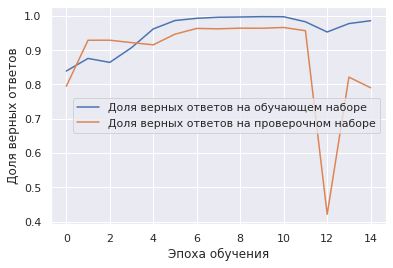

In [101]:
history = model.fit(xTrain, yTrain, epochs=15, batch_size=5, validation_split=0.1)

plt.plot(history.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [102]:
score = model.evaluate(xTest, yTest)

4/4 [==============================] - 1s 195ms/step - loss: 0.4886 - dice_coef: 0.8134


In [103]:
score

[0.4885972738265991, 0.8133810758590698]